# Europe’s fragmenting urban landscape using high-resolution dynamic models to characterize spatial developments 

In [1]:
# Import required Python modules
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show

import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patheffects as pe

from scipy.ndimage import label
from scipy.ndimage import labeled_comprehension

import pickle
import os

# 1 Data and study area

In [2]:
# Load a geodataframe of functional urban areas (FUAs) in European OECD countries 
# with units of built-up urban growth between 1975-2014 
# The file countries_gpd.pkl can be downloaded at https://figshare.com/s/170e755205066de20857.
countries_gpd = pd.read_pickle(
    r"C:\Users\jyu5\Desktop\GlobalSustainableUrbanSpatialDevelopments\previous_code\reuslts_OECD\countries_gpd.pkl")
FUAs = countries_gpd['eFUA_name'].to_list()
countries = countries_gpd['Cntry_name'].to_list()

In [3]:
countries_gpd.head()

,eFUA_name,Cntry_name,FUA_area,UC_area,geometry,1975 urban,1990 urban,2000 urban,2014 urban,90-00 UG,00-14 UG,75-90 UG
252,Innsbruck,Austria,352.0,27.0,"MULTIPOLYGON (((914000.000 5590000.000, 916000...",855.0,957,1078,1173,121,95,102.0
253,Salzburg,Austria,368.0,46.0,"MULTIPOLYGON (((1031000.000 5652000.000, 10320...",1015.0,1114,1266,1421,152,155,99.0
254,Linz,Austria,875.0,69.0,"MULTIPOLYGON (((1116000.000 5708000.000, 11250...",1908.0,2214,2555,2879,341,324,306.0
255,Klagenfurt,Austria,462.0,26.0,"MULTIPOLYGON (((1139000.000 5531000.000, 11400...",847.0,967,1027,1167,60,140,120.0
256,Graz,Austria,978.0,73.0,"MULTIPOLYGON (((1206000.000 5582000.000, 12070...",1420.0,1440,1743,1930,303,187,20.0


In [ ]:
# # Pre-processing to generate the above geodataframe countries_gpd.pkl

# # The GHSL built-up data publicly available with identifiers doi: 10.2905/jrc-ghsl-10007
# ghs_built_raster_paths = [r'data\GHS_BUILT_LDS1975_GLOBE_R2018A_54009_250_V2_0\GHS_BUILT_LDS1975_GLOBE_R2018A_54009_250_V2_0.tif',
#                           r'data\GHS_BUILT_LDS1990_GLOBE_R2018A_54009_250_V2_0\GHS_BUILT_LDS1990_GLOBE_R2018A_54009_250_V2_0.tif',
#                           r'data\GHS_BUILT_LDS2000_GLOBE_R2018A_54009_250_V2_0\GHS_BUILT_LDS2000_GLOBE_R2018A_54009_250_V2_0.tif',
#                           r'data\GHS_BUILT_LDS2014_GLOBE_R2018A_54009_250_V2_0\GHS_BUILT_LDS2014_GLOBE_R2018A_54009_250_V2_0.tif']
# years = ['1975','1990','2000','2014']

# # A helper function to binary urban reclassify GHSL cells with >20% urban as urban in this study
# def categorize_urban(percent):
#     if percent >= 50: #urban centre
#         return 1
#     if percent >= 20 and percent < 50: #urban cluster
#         return 1 
#     if percent >= 0 and percent < 20: #non-urban
#         return 0 
#     if percent < 0: #no value
#         return -200
# # Vectorize the reclassify function
# categorize_urban_vec = np.vectorize(categorize_urban)

# #function to crop urban areas from GHSL raster by FUA delineation, reclassify into binary urban,non-urban, 
# #and returns an urban area's built-up map within fua boundary
# #at GHSL time points 1975, 1990, 2000, 2014 and the increased urban units between these time points.
# def GrowthUnits_InitialMap(CntyName,FUAname):
#     """
#     This function to crop urban areas from GHSL raster by FUA delineation, reclassify into binary urban,non-urban, 
#     and returns an urban area's built-up map within fua boundary
#     at GHSL time points 1975, 1990, 2000, 2014 and the increased urban units between these time points.
#     Input: country name, fua name in GHSL data
#     Output: a list of cropped rasters of an fua at four GHSL time points 1975, 1990, 2000, 2014 
#             (and the growth units between three GHSL periods 1975-1990, 1975-2000, 1975-2014).
#     """
# #     fua_gdf = gpd.read_file(r'data\GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0\GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')
#     country_gpd = fua_gdf[fua_gdf['Cntry_name']==CntyName]
#     shape = country_gpd[country_gpd['eFUA_name']==FUAname].iloc[0]['geometry']
#     with rio.open(ghs_built_raster_paths[0]) as src:    
#         out_img, out_transform = mask(src, shape, crop=True)
#     categorized_FUA_1975 = np.squeeze(categorize_urban_vec(out_img))
#     with rio.open(ghs_built_raster_paths[1]) as src:    
#         out_img, out_transform = mask(src, shape, crop=True)
#     categorized_FUA_1990 = np.squeeze(categorize_urban_vec(out_img))
#     with rio.open(ghs_built_raster_paths[2]) as src:    
#         out_img, out_transform = mask(src, shape, crop=True)
#     categorized_FUA_2000 = np.squeeze(categorize_urban_vec(out_img))
#     with rio.open(ghs_built_raster_paths[3]) as src:    
#         out_img, out_transform = mask(src, shape, crop=True)
#     categorized_FUA_2014 = np.squeeze(categorize_urban_vec(out_img))
#     #1975-1990 Dresden: +593
#     GrownUrbanUnits_1975_1990 = np.unique(categorized_FUA_1990,return_counts=True)[1][2]-np.unique(categorized_FUA_1975,return_counts=True)[1][2]
#     #1975-2000 Dresden: +1153
#     GrownUrbanUnits_1975_2000 = np.unique(categorized_FUA_2000,return_counts=True)[1][2]-np.unique(categorized_FUA_1975,return_counts=True)[1][2]
#     #1975-2014 Dresden: +1485
#     GrownUrbanUnits_1975_2014 = np.unique(categorized_FUA_2014,return_counts=True)[1][2]-np.unique(categorized_FUA_1975,return_counts=True)[1][2]
#     categorized_fuas = [categorized_FUA_1975,categorized_FUA_1990,categorized_FUA_2000,categorized_FUA_2014]
#     growth_units = [GrownUrbanUnits_1975_1990,GrownUrbanUnits_1975_2000,GrownUrbanUnits_1975_2014]
#     return categorized_fuas,growth_units

# #Create a countries geodataframe, with rows of fuas from countries of interest, 
# #columns of fua_name, cntry_name, fua_area, UC_area, fua geometry, urban units at 1975, 1990, 2000, 2014,
# #and urban growth between 75-90, 90-00, 00-14
# countries = ['Austria','CzechRepublic', 'Denmark', 'Estonia', 'Finland', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Luxembourg', 'Norway', 'Poland', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey']+['France','UnitedKingdom','Netherlands',
#              'Belgium','Germany']
# # The functional urban area data publicly available with identifier:10.2905/347F0337-F2DA-4592-87B3-E25975EC2C95
# fua_gdf = gpd.read_file(r'data\GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0\GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')
# countries_gpd = fua_gdf[fua_gdf['Cntry_name'].isin(countries)]
# countries_gpd = countries_gpd[['eFUA_name','Cntry_name','FUA_area','UC_area','geometry']]

# #create columns - urban units at 1975, 1990, 2000, 2014,and urban growth between 75-90, 90-00, 00-14
# def urban_units1975(x):
#     shape = x['geometry']
#     with rio.open(ghs_built_raster_paths[0]) as src:    
#         out_img, out_transform = mask(src, shape, crop=True)
#     categorized_FUA_1975 = np.squeeze(categorize_urban_vec(out_img))
#     try:
#         x['1975 urban']=np.unique(categorized_FUA_1975,return_counts=True)[1][2]
#     except:
#         x['1975 urban']=np.nan
#     return x

# def urban_units1990(x):
#     shape = x['geometry']
#     with rio.open(ghs_built_raster_paths[1]) as src:    
#         out_img, out_transform = mask(src, shape, crop=True)
#     categorized_FUA_1990 = np.squeeze(categorize_urban_vec(out_img))
#     try:
#         x['1990 urban']=np.unique(categorized_FUA_1990,return_counts=True)[1][2]
#     except:
#         x['1990 urban']=np.nan
#     return x

# def urban_units2000(x):
#     shape = x['geometry']
#     with rio.open(ghs_built_raster_paths[2]) as src:    
#         out_img, out_transform = mask(src, shape, crop=True)
#     categorized_FUA_2000 = np.squeeze(categorize_urban_vec(out_img))
#     try:
#         x['2000 urban']=np.unique(categorized_FUA_2000,return_counts=True)[1][2]
#     except:
#         x['2000 urban']=np.nan
#     return x

# def urban_units2014(x):
#     shape = x['geometry']
#     with rio.open(ghs_built_raster_paths[3]) as src:    
#         out_img, out_transform = mask(src, shape, crop=True)
#     categorized_FUA_2014 = np.squeeze(categorize_urban_vec(out_img))
#     try:
#         x['2014 urban']=np.unique(categorized_FUA_2014,return_counts=True)[1][2]
#     except:
#         x['2014 urban']=np.nan
#     return x

# countries_gpd = countries_gpd.apply(urban_units1975,axis=1)
# countries_gpd = countries_gpd.apply(urban_units1990,axis=1)
# countries_gpd = countries_gpd.apply(urban_units2000,axis=1)
# countries_gpd = countries_gpd.apply(urban_units2014,axis=1)
# countries_gpd.dropna(inplace=True)

# countries_gpd['90-00 UG'] = countries_gpd['2000 urban']-countries_gpd['1990 urban'] 
# countries_gpd['00-14 UG'] = countries_gpd['2014 urban']-countries_gpd['2000 urban'] 
# countries_gpd['75-90 UG'] = countries_gpd['1990 urban']-countries_gpd['1975 urban'] 

# #Keep only the FUAs with urban growth
# countries_gpd = countries_gpd[(countries_gpd['75-90 UG']>0)&(countries_gpd['90-00 UG']>0)&(countries_gpd['00-14 UG']>0)]

# #Store the geodataframe in countries_gpd.pkl
# countries_gpd.to_pickle("results_OECD\countries_gpd.pkl")

In [5]:
# Some country names in GHSL area different from eurostat
country_names = list(set(countries))
country_names

['Slovakia',
 'Poland',
 'Spain',
 'Greece',
 'Norway',
 'Ireland',
 'Belgium',
 'Sweden',
 'Denmark',
 'Turkey',
 'Germany',
 'Switzerland',
 'UnitedKingdom',
 'Netherlands',
 'Slovenia',
 'Italy',
 'Finland',
 'Luxembourg',
 'Estonia',
 'Portugal',
 'Austria',
 'Hungary',
 'France',
 'CzechRepublic']

In [6]:
# Change the GHSL names to eurostat country name
country_names[12] = 'United Kingdom'
country_names[-1]='Czechia'

In [9]:
# Load the eurostate Countries Administrative boundaries data publicly available at
# https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/countries

eu_gdf = gpd.read_file(r'C:\Users\jyu5\Desktop\GlobalSustainableUrbanSpatialDevelopments\data\delineation\ref-countries-2020-01m.gdb\ref-countries-2020-01m.gdb')
eu_gdf = eu_gdf.to_crs('ESRI:54009')

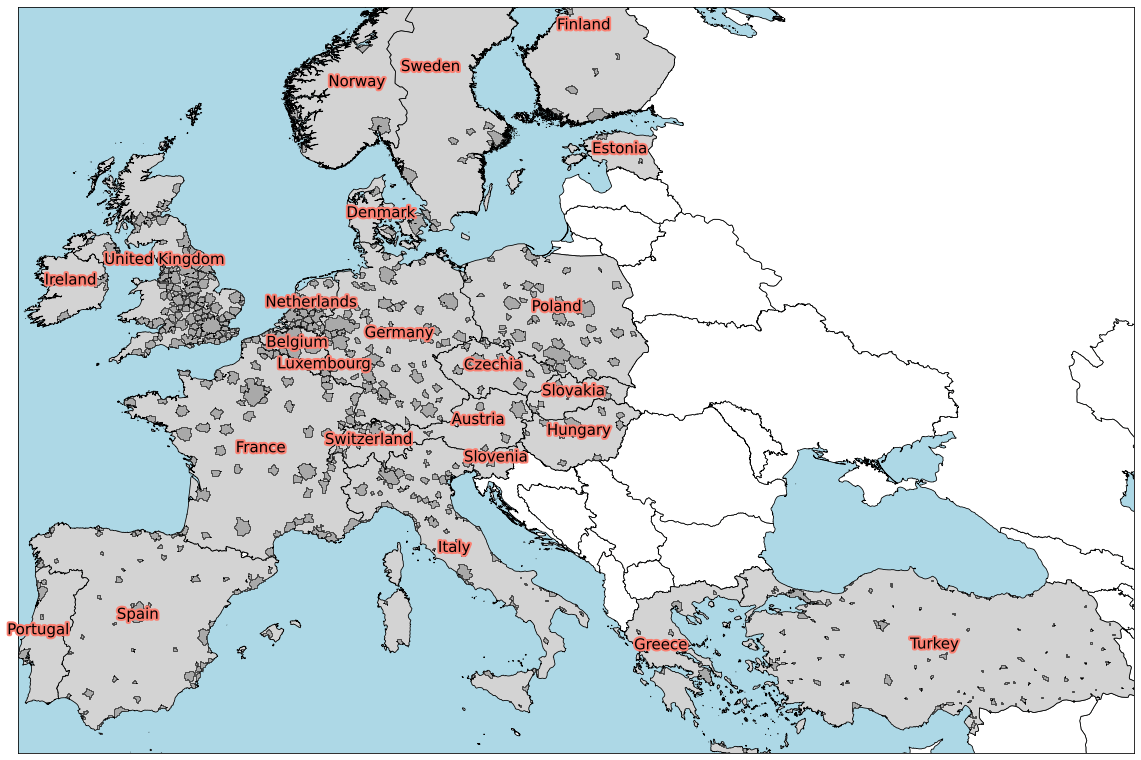

In [11]:
# Include neighbouring countries not analyzed for mapping
non_OECDEU = ['Albania','Andorra','Armenia','Azerbaijan','Belarus','Bosnia and Herzegovina','Bulgaria','Croatia','Cyprus','Georgia','Kazakhstan','Latvia','Liechtenstein','Lithuania','Malta','Moldova','Monaco','Montenegro','North Macedonia','Romania','Russian Federation','San Marino','Serbia','Ukraine']
bourdering = ['Iran','Iraq','Syria']

EU_map_countries = country_names+non_OECDEU+bourdering

# Adjust country name notation
cntyname_annotations = [((1.10768e+06, 5.61764e+06), 'Austria'),((351980, 5.93993e+06), 'Belgium'),
                        ((651122, 5.53395e+06), 'Switzerland'),((701612, 6.48093e+06), 'Denmark'),
                        ((1.69881e+06, 6.74812e+06), 'Estonia'),((1.86961e+06, 4.67712e+06), 'Greece'),
                        ((1.17062e+06, 5.84537e+06), 'Czechia'),((777853, 5.97984e+06), 'Germany'),
                        ((200000, 5.5e+06), 'France'),((1.54904e+06, 7.26525e+06), 'Finland'),
                        ((1.52867e+06, 5.57246e+06), 'Hungary'),((-593591, 6.20001e+06), 'Ireland'),
                        ((1.00735e+06, 5.08358e+06), 'Italy'),((464790, 5.85001e+06), 'Luxembourg'),
                        ((411353, 6.1078e+06), 'Netherlands'),((601144, 7.028e+06), 'Norway'),
                        ((1.43573e+06, 6.08897e+06), 'Poland'),((-728429, 4.73992e+06), 'Portugal'),
                        ((0.90898e+06, 7.09125e+06), 'Sweden'),((1.18201e+06, 5.46099e+06), 'Slovenia'),
                        ((1.50621e+06, 5.73703e+06), 'Slovakia'),((3.01291e+06, 4.68042e+06), 'Turkey'),
                        ((-201445, 6.28578e+06), 'United Kingdom'),((-312991, 4.80445e+06), 'Spain')]

# Map the study areas
# Generate figure 3 in the article
xmin, ymin, xmax, ymax = countries_gpd.total_bounds
fig, axes = plt.subplots(1,1,figsize=(20,15))

eu_gdf[eu_gdf['NAME_ENGL'].isin(non_OECDEU+bourdering)].plot(ax=axes,ec='k',linewidth=0.8,color='white')
eu_gdf[eu_gdf['NAME_ENGL'].isin(country_names)].plot(ax=axes,ec='k',linewidth=0.8,color='lightgrey')
countries_gpd.plot(ax=axes,fc='darkgrey',ec='k',linewidth=0.6)
axes.set_xlim(xmin, xmax) 
axes.set_ylim(ymin, ymax)
axes.set_facecolor('lightblue')
axes.tick_params(labelbottom=False,labelleft=False,axis=u'both', which=u'both',length=0)  
for t in cntyname_annotations :
    axes.annotate(text=t[1], xy=t[0], ha='center',fontsize=15,color='k',path_effects=[pe.withStroke(linewidth=4, foreground="salmon")])

# 2 Methodology

In [14]:
# Load four urban growth modes/clusters' simulated urban spatial development scenarios of all FUAs
# The simulations are stored in Python pickles and can be found at: https://figshare.com/s/6bde6530cd12563b7221

with open(r'C:\Users\jyu5\Desktop\GlobalSustainableUrbanSpatialDevelopments\previous_code\reuslts_OECD\compact_scenario.pkl', 'rb') as f:
    compact_scenario = pickle.load(f)
with open(r'C:\Users\jyu5\Desktop\GlobalSustainableUrbanSpatialDevelopments\previous_code\reuslts_OECD\mediumcompact_scenario.pkl', 'rb') as f:
    mediumcompact_scenario = pickle.load(f)
with open(r'C:\Users\jyu5\Desktop\GlobalSustainableUrbanSpatialDevelopments\previous_code\reuslts_OECD\mediumdisperse_scenario.pkl', 'rb') as f:
    mediumdisperse_scenario = pickle.load(f)
with open(r'C:\Users\jyu5\Desktop\GlobalSustainableUrbanSpatialDevelopments\previous_code\reuslts_OECD\disperse_scenario.pkl', 'rb') as f:
    disperse_scenario = pickle.load(f)
    
# Load fact maps of functional urban areas, binarily classified with urban, non-urban land uses
# These reclassified maps can be found at: https://figshare.com/s/406b4f8506dfdb80e9b6
with open(r'C:\Users\jyu5\Desktop\GlobalSustainableUrbanSpatialDevelopments\previous_code\reuslts_OECD\categorized_FUA_1975s.pickle', 'rb') as handle:
    categorized_FUA_1975s = pickle.load(handle)
with open(r'C:\Users\jyu5\Desktop\GlobalSustainableUrbanSpatialDevelopments\previous_code\reuslts_OECD\categorized_FUA_1990s.pickle', 'rb') as handle:
    categorized_FUA_1990s = pickle.load(handle)
with open(r'C:\Users\jyu5\Desktop\GlobalSustainableUrbanSpatialDevelopments\previous_code\reuslts_OECD\categorized_FUA_2000s.pickle', 'rb') as handle:
    categorized_FUA_2000s = pickle.load(handle)
with open(r'C:\Users\jyu5\Desktop\GlobalSustainableUrbanSpatialDevelopments\previous_code\reuslts_OECD\categorized_FUA_2014s.pickle', 'rb') as handle:
    categorized_FUA_2014s = pickle.load(handle)

# Load the affine transform for mapping, found at https://figshare.com/s/406b4f8506dfdb80e9b6
with open(r'C:\Users\jyu5\Desktop\GlobalSustainableUrbanSpatialDevelopments\previous_code\reuslts_OECD\out_transforms1975.pkl', 'rb') as f:
    out_transforms1975 = pickle.load(f)
with open(r'C:\Users\jyu5\Desktop\GlobalSustainableUrbanSpatialDevelopments\previous_code\reuslts_OECD\out_transforms2014.pkl', 'rb') as f:
    out_transforms2014 = pickle.load(f)

In [ ]:
# Pre-processing to generate the above urban growth modes/clusters' simulations
#Prepare ASCII raster for MCK - changes predictions
# Load the parameters for urban spatial development scenarios projection
# The parameters can be found at: https://figshare.com/s/650730f9e6fedc44ac1a
# paths = [ r'results_EU\changes_kl\Avignon_m_chain2.npy',r'results_EU\changes_kl\Poitiers_m_chain2.npy',
#          r'results_EU\changes_kl\Belfast_m_chain2.npy',r'results_EU\changes_kl\Blackwater_m_chain2.npy',
#          r'results_EU\changes_kl\Enschede_m_chain2.npy',r'results_EU\changes_kl\Utrecht_m_chain2.npy',
#          r'results_EU\changes_kl\Leuven_m_chain2.npy',r'results_EU\changes_kl\Mons_m_chain2.npy', 
#          r'results_EU\changes_kl\Mönchengladbach_m_chain2.npy',r'results_EU\changes_kl\Wuppertal_m_chain2.npy']

# chains = [np.load(path,allow_pickle=True) for path in paths]
# paras_best20 = [chain[0][chain[2].argsort()[:20]] for chain in chains]
# seeds_best20 = [chain[1][chain[2].argsort()[:20]] for chain in chains]

# paraFUAs = [ 'Avignon','Poitiers','Belfast','Blackwater','Enschede','Utrecht','Leuven',
#         'Mons','Mönchengladbach','Wuppertal']

# # Calculate the growth units
# growth_num7590 = [np.sum(categorized_FUA_1990s[j],where=categorized_FUA_1990s[j]==1)-\
#                   np.sum(categorized_FUA_1975s[j],where=categorized_FUA_1975s[j]==1) for j in range(len(FUAs))]
# growth_num9000 = [np.sum(categorized_FUA_2000s[j],where=categorized_FUA_2000s[j]==1)-\
#                   np.sum(categorized_FUA_1990s[j],where=categorized_FUA_1990s[j]==1) for j in range(len(FUAs))]
# growth_num0014 = [np.sum(categorized_FUA_2014s[j],where=categorized_FUA_2014s[j]==1)-\
#                   np.sum(categorized_FUA_2000s[j],where=categorized_FUA_2000s[j]==1) for j in range(len(FUAs))]
# genesis_growth_nums1975 = [sum(categorized_FUA_1975s[i][categorized_FUA_1975s[i]==1]) for i in range(len(FUAs))]

# # Generate system paths
# newpath = r'results_OECD\changes0014'
# if not os.path.exists(newpath):
#     os.makedirs(newpath)
# for i in range(len(FUAs)):
#     newpath = r'results_OECD\changes0014\\'+FUAs[i]
#     if not os.path.exists(newpath):
#         os.makedirs(newpath)

# newpath = r'results_OECD\changes9000'
# if not os.path.exists(newpath):
#     os.makedirs(newpath)
# for i in range(len(FUAs)):
#     newpath = r'results_OECD\changes9000\\'+FUAs[i]
#     if not os.path.exists(newpath):
#         os.makedirs(newpath)
        
# newpath = r'results_OECD\changes7590'
# if not os.path.exists(newpath):
#     os.makedirs(newpath)
# for i in range(len(FUAs)):
#     newpath = r'results_OECD\changes7590\\'+FUAs[i]
#     if not os.path.exists(newpath):
#         os.makedirs(newpath)
    
# newpath = r'results_OECD\genesis75'
# if not os.path.exists(newpath):
#     os.makedirs(newpath)
# for i in range(len(FUAs)):
#     newpath = r'results_OECD\genesis75\\'+FUAs[i]
#     if not os.path.exists(newpath):
#         os.makedirs(newpath)
        
# # Generate the different spatial development scenario projections for all FUAs
# # The CCA_EU is a cellular automata model that can be found at https://github.com/JingyanYu/LandUseDecisions
# for j in range(len(FUAs)):
#     categorized_FUA_2000 = categorized_FUA_2000s[j]
#     rows, cols = categorized_FUA_2000.shape
#     urban_num = growth_num0014[j]
#     for i in range(len(paraFUAs)):
#         for n in range(20):
#             paras = paras_best20[i][n]
#             seed =seeds_best20[i][n]
#             result = CCA_EU.CCA_last_snapshot([paras[0],0,paras[1]],[0,paras[2],paras[3]],
#                                               seed=seed,landmap=categorized_FUA_2000.copy(),
#                                               rows=rows,cols=cols,urban_num=urban_num,trans_num=15) 
#             header_acsiiraster = "ncols "+str(cols)+"\nnrows "+str(rows)+"\nxllcorner     0.0\nyllcorner     0.0\ncellsize      1.0\nNODATA_value  -200\n"
#             path = "results_OECD\changes0014\\"+FUAs[j]+'\\'+paraFUAs[i]+'7500changes_predict'+FUAs[j]+"0014changes_"+str(n)+".asc"
#             np.savetxt(path, result, delimiter=' ',header=header_acsiiraster,fmt='%i',comments='')

# for j in range(len(FUAs)):
#     categorized_FUA_1990 = categorized_FUA_1990s[j]
#     rows, cols = categorized_FUA_1990.shape
#     urban_num = growth_num9000[j]
#     for i in range(len(paraFUAs)):
#         for n in range(20):
#             paras = paras_best20[i][n]
#             seed =seeds_best20[i][n]
#             result = CCA_EU.CCA_last_snapshot([paras[0],0,paras[1]],[0,paras[2],paras[3]],
#                                               seed=seed,landmap=categorized_FUA_1990.copy(),
#                                               rows=rows,cols=cols,urban_num=urban_num,trans_num=15) 
#             header_acsiiraster = "ncols "+str(cols)+"\nnrows "+str(rows)+"\nxllcorner     0.0\nyllcorner     0.0\ncellsize      1.0\nNODATA_value  -200\n"
#             path = "results_OECD\changes9000\\"+FUAs[j]+'\\'+paraFUAs[i]+'7500changes_predict'+FUAs[j]+"9000changes_"+str(n)+".asc"
#             np.savetxt(path, result, delimiter=' ',header=header_acsiiraster,fmt='%i',comments='')            
            
# for j in range(len(FUAs)):
#     categorized_FUA_1975 = categorized_FUA_1975s[j]
#     rows, cols = categorized_FUA_1975.shape
#     urban_num = growth_num7590[j]
#     for i in range(len(paraFUAs)):
#         for n in range(20):
#             paras = paras_best20[i][n]
#             seed =seeds_best20[i][n]
#             result = CCA_EU.CCA_last_snapshot([paras[0],0,paras[1]],[0,paras[2],paras[3]],
#                                               seed=seed,landmap=categorized_FUA_1975.copy(),
#                                               rows=rows,cols=cols,urban_num=urban_num,trans_num=15) 
#             header_acsiiraster = "ncols "+str(cols)+"\nnrows "+str(rows)+"\nxllcorner     0.0\nyllcorner     0.0\ncellsize      1.0\nNODATA_value  -200\n"
#             path = "results_OECD\changes7590\\"+FUAs[j]+'\\'+paraFUAs[i]+'7500changes_predict'+FUAs[j]+"7590changes_"+str(n)+".asc"
#             np.savetxt(path, result, delimiter=' ',header=header_acsiiraster,fmt='%i',comments='')

# for j in range(len(FUAs)):
#     rows, cols = categorized_FUA_1975s[j].shape
#     initialmap = categorized_FUA_1975s[j].copy()
#     initialmap[initialmap==1]=0
#     urban_num = genesis_growth_nums1975[j]
#     for i in range(len(paraFUAs)):
#         for n in range(20):
#             paras = paras_best20[i][n]
#             seed =seeds_best20[i][n]
#             result = CCA_EU.CCA_last_snapshot([paras[0],0,paras[1]],[0,paras[2],paras[3]],
#                                               seed=seed,landmap=initialmap.copy(),
#                                               rows=rows,cols=cols,urban_num=urban_num,trans_num=15) 
#             header_acsiiraster = "ncols "+str(cols)+"\nnrows "+str(rows)+"\nxllcorner     0.0\nyllcorner     0.0\ncellsize      1.0\nNODATA_value  -200\n"
#             path = "results_OECD\genesis75\\"+FUAs[j]+'\\'+paraFUAs[i]+"7500changes_predict"+FUAs[j]+"1975genesis_"+str(n)+".asc"
#             np.savetxt(path, result, delimiter=' ',header=header_acsiiraster,fmt='%i',comments='')

# # Load the parameters for urban spatial development scenarios projection
# # The parameters can be found at: https://figshare.com/s/650730f9e6fedc44ac1a
# paths = [ r'results_EU\pattern_kl\Avignon_m_chain2.npy',r'results_EU\pattern_kl\Poitiers_m_chain2.npy',
#          r'results_EU\pattern_kl\Belfast_m_chain2.npy',r'results_EU\pattern_kl\Blackwater_m_chain2.npy',
#          r'results_EU\pattern_kl\Enschede_m_chain2.npy',r'results_EU\pattern_kl\Utrecht_m_chain2.npy',
#          r'results_EU\pattern_kl\Leuven_m_chain2.npy', r'results_EU\pattern_kl\Mons_m_chain2.npy', 
#          r'results_EU\pattern_kl\Mönchengladbach_m_chain2.npy',r'results_EU\pattern_kl\Wuppertal_m_chain2.npy']

# chains = [np.load(path,allow_pickle=True) for path in paths]
# paras_best20 = [chain[0][chain[2].argsort()[:20]] for chain in chains]
# seeds_best20 = [chain[1][chain[2].argsort()[:20]] for chain in chains]

# for j in range(len(FUAs)):
#     categorized_FUA_1975 = categorized_FUA_1975s[j]
#     rows, cols = categorized_FUA_1975.shape
#     urban_num = growth_num7590[j]
#     for i in range(len(paraFUAs)):
#         for n in range(20):
#             paras = paras_best20[i][n]
#             seed =seeds_best20[i][n]
#             result = CCA_EU.CCA_last_snapshot([paras[0],0,paras[1]],[0,paras[2],paras[3]],
#                                               seed=seed,landmap=categorized_FUA_1975.copy(),
#                                               rows=rows,cols=cols,urban_num=urban_num,trans_num=15) 
#             header_acsiiraster = "ncols "+str(cols)+"\nnrows "+str(rows)+"\nxllcorner     0.0\nyllcorner     0.0\ncellsize      1.0\nNODATA_value  -200\n"
#             path = "results_OECD\changes7590\\"+FUAs[j]+'\\'+paraFUAs[i]+'2000pattern_predict'+FUAs[j]+"7590changes_"+str(n)+".asc"
#             np.savetxt(path, result, delimiter=' ',header=header_acsiiraster,fmt='%i',comments='')
# for j in range(len(FUAs)):
#     categorized_FUA_1990 = categorized_FUA_1990s[j]
#     rows, cols = categorized_FUA_1990.shape
#     urban_num = growth_num9000[j]
#     for i in range(len(paraFUAs)):
#         for n in range(20):
#             paras = paras_best20[i][n]
#             seed =seeds_best20[i][n]
#             result = CCA_EU.CCA_last_snapshot([paras[0],0,paras[1]],[0,paras[2],paras[3]],
#                                               seed=seed,landmap=categorized_FUA_1990.copy(),
#                                               rows=rows,cols=cols,urban_num=urban_num,trans_num=15) 
#             header_acsiiraster = "ncols "+str(cols)+"\nnrows "+str(rows)+"\nxllcorner     0.0\nyllcorner     0.0\ncellsize      1.0\nNODATA_value  -200\n"
#             path = "results_OECD\changes9000\\"+FUAs[j]+'\\'+paraFUAs[i]+'2000pattern_predict'+FUAs[j]+"9000changes_"+str(n)+".asc"
#             np.savetxt(path, result, delimiter=' ',header=header_acsiiraster,fmt='%i',comments='')

# for j in range(len(FUAs)):
#     categorized_FUA_2000 = categorized_FUA_2000s[j]
#     rows, cols = categorized_FUA_2000.shape
#     urban_num = growth_num0014[j]
#     for i in range(len(paraFUAs)):
#         for n in range(20):
#             paras = paras_best20[i][n]
#             seed =seeds_best20[i][n]
#             result = CCA_EU.CCA_last_snapshot([paras[0],0,paras[1]],[0,paras[2],paras[3]],
#                                               seed=seed,landmap=categorized_FUA_2000.copy(),
#                                               rows=rows,cols=cols,urban_num=urban_num,trans_num=15) 
#             header_acsiiraster = "ncols "+str(cols)+"\nnrows "+str(rows)+"\nxllcorner     0.0\nyllcorner     0.0\ncellsize      1.0\nNODATA_value  -200\n"
#             path = "results_OECD\changes0014\\"+FUAs[j]+'\\'+paraFUAs[i]+'2000pattern_predict'+FUAs[j]+"0014changes_"+str(n)+".asc"
#             np.savetxt(path, result, delimiter=' ',header=header_acsiiraster,fmt='%i',comments='')

# for j in range(len(FUAs)):
#     rows, cols = categorized_FUA_1975s[j].shape
#     initialmap = categorized_FUA_1975s[j].copy()
#     initialmap[initialmap==1]=0
#     urban_num = genesis_growth_nums1975[j]
#     for i in range(len(paraFUAs)):
#         for n in range(20):
#             paras = paras_best20[i][n]
#             seed =seeds_best20[i][n]
#             result = CCA_EU.CCA_last_snapshot([paras[0],0,paras[1]],[0,paras[2],paras[3]],
#                                               seed=seed,landmap=initialmap.copy(),
#                                               rows=rows,cols=cols,urban_num=urban_num,trans_num=15) 
#             header_acsiiraster = "ncols "+str(cols)+"\nnrows "+str(rows)+"\nxllcorner     0.0\nyllcorner     0.0\ncellsize      1.0\nNODATA_value  -200\n"
#             path = "results_OECD\genesis75\\"+FUAs[j]+'\\'+paraFUAs[i]+"2000pattern_predict"+FUAs[j]+"1975genesis_"+str(n)+".asc"
#             np.savetxt(path, result, delimiter=' ',header=header_acsiiraster,fmt='%i',comments='')

In [15]:
# Helper functions to well-recognized spatial configuration metrics
def largest_patch_size(obs):
    obs_labeled_array, obs_num_features = label(obs)
    obs_patch_sizes = labeled_comprehension(obs,obs_labeled_array,np.arange(1, obs_num_features+1), len, float, 0)
    return np.amax(obs_patch_sizes)

def patch_size(obs):
    obs_labeled_array, obs_num_features = label(obs)
#     obs_patch_sizes = labeled_comprehension(obs,obs_labeled_array,np.arange(1, obs_num_features+1), len, float, 0)
    return obs_num_features

# Defined by https://doi.org/10.1080/17538947.2018.1474957
def DI(obs):
    obs_labeled_array, obs_num_features = label(obs)
    obs_patch_sizes = labeled_comprehension(obs,obs_labeled_array,np.arange(1, obs_num_features+1), len, float, 0)
    NP = obs_num_features
    LP = np.amax(obs_patch_sizes)/sum(obs_patch_sizes)*100
    NPN = (NP-1)/(sum(obs_patch_sizes)-1)*100
    LPN = (LP-1/sum(obs_patch_sizes))/(100-1/sum(obs_patch_sizes))*100
    return (NPN+(100-LPN))/2

#https://gist.github.com/viveksck/1110dfca01e4ec2c608515f0d5a5b1d1
def fractal_dimension(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

In [17]:
#Create a helper function to visualize an FUA's real growth and four spatial development scenarios - compact to diseprsed
# Accompanied by the well-recognized spatial configuration metrics' measurements
def plot_fua_scenarios(country,fua):
    fua = fua
    idx = FUAs.index(fua)
    result_plots = [categorized_FUA_2014s[idx].copy(),compact_scenario[idx],mediumcompact_scenario[idx],
                    mediumdisperse_scenario[idx],disperse_scenario[idx]]
#     titles = ['Observed 1975-2014 urban growth','Compact scenario','Medium compact scenario','Medium dispersed scenario','Dispersed scenario']
    changes_colours = ListedColormap(['none','k'])
    cmap = ListedColormap(["none","none", "grey"])
#     xmin, ymin, xmax, ymax = countries_gpd[countries_gpd['eFUA_name']== fua]['geometry'].bounds.values.flatten()
    fig, axes = plt.subplots(5,1,figsize=(3,13))
    for i in range(5):
        x = float(countries_gpd[(countries_gpd['Cntry_name']==country)&(countries_gpd['eFUA_name']==fua)]['geometry'].centroid.x)
        y = float(countries_gpd[(countries_gpd['Cntry_name']==country)&(countries_gpd['eFUA_name']==fua)]['geometry'].centroid.y)
        xmin, ymin, xmax, ymax = x-10000,y-10000,x+10000,y+10000
        axes[i].set_xlim(xmin,xmax)
        axes[i].set_ylim(ymin,ymax)
        axes[i].tick_params(labelbottom=False,labelleft=False,axis=u'both', which=u'both',length=0)
#         axes[i].axis('off')
        countries_gpd[(countries_gpd['Cntry_name']==country)&(countries_gpd['eFUA_name']==fua)].boundary.plot(ax=axes[i],ec='darkgrey',linewidth=2)
#         if i == 0:
#             countries_gpd[(countries_gpd['Cntry_name']==country)&(countries_gpd['eFUA_name']==fua)].apply(
#             lambda x: axes[i].annotate(text=x.eFUA_name+'\n'+x.Cntry_name, xy=x.geometry.centroid.coords[0], ha='center',fontsize=20,c='orange', weight='bold'), axis=1)
        result_plot = categorized_FUA_1975s[idx].copy()
        result_plot[result_plot==-200]=-1
        show(result_plot, ax=axes[i], transform=out_transforms1975[idx],cmap=cmap)       
        previous = categorized_FUA_1975s[idx].copy()
        previous[previous==-200]=0
        if i==0:
            di_pre = DI(previous)
            fd_pre = fractal_dimension(previous)
        result_plot = result_plots[i].copy()
        result_plot[result_plot==-200]=0
        di = DI(result_plot)
        fd = fractal_dimension(result_plot)
        changes = result_plot-previous
        show(changes,ax=axes[i],cmap=changes_colours,transform=out_transforms2014[idx])
        
        if i==0:
            axes[i].set_title('$DI^{Obs}_{1975}=%.2f \quad FD^{Obs}_{1975}=%.2f$ \n$DI^{Obs}_{2014}=%.2f \quad FD^{Obs}_{2014}=%.2f$'%(di_pre,fd_pre,di,fd))
        elif i==1:
            axes[i].set_title('$DI^{Cmpt}_{2014}=%.2f \quad FD^{Cmpt}_{2014}=%.2f$'%(di,fd))
        elif i==2:
            axes[i].set_title('$DI^{MedCmpt}_{2014}=%.2f \quad FD^{MedCmpt}_{2014}=%.2f$'%(di,fd))
        elif i==3:
            axes[i].set_title('$DI^{MedDisp}_{2014}=%.2f \quad FD^{MedDisp}_{2014}=%.2f$'%(di,fd))
        elif i==4:
            axes[i].set_title('$DI^{Disp}_{2014}=%.2f \quad FD^{Disp}_{2014}=%.2f$'%(di,fd))

    fig.tight_layout()

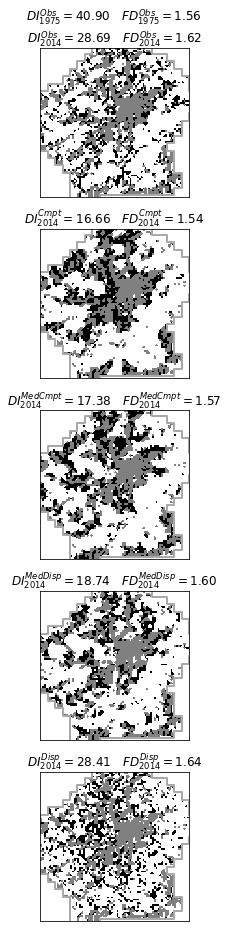

In [18]:
# Generate figure 4 & 5 in the article
plot_fua_scenarios('Portugal','Braga')

# 3. Result analysis

In [21]:
# Load KS statistics between observed urban density distribution of FUAs and their four scenario projections
# Found at: https://figshare.com/s/183cfcb08672548f1db1
with open(os.path.abspath(r'.\reuslts_OECD\ks_values1975change.pickle'), 'rb') as handle:
    ks_values1975change = pickle.load(handle)
with open(os.path.abspath(r'.\reuslts_OECD\ks_values7590change.pickle'), 'rb') as handle:
    ks_values7590change = pickle.load(handle)
with open(os.path.abspath(r'.\reuslts_OECD\ks_values9000change.pickle'), 'rb') as handle:
    ks_values9000change = pickle.load(handle)
with open(os.path.abspath(r'.\reuslts_OECD\ks_values0014change.pickle'), 'rb') as handle:
    ks_values0014change = pickle.load(handle)

with open(os.path.abspath(r'.\reuslts_OECD\ks_values1975genesis.pickle'), 'rb') as handle:
    ks_values1975genesis = pickle.load(handle)
with open(os.path.abspath(r'.\reuslts_OECD\ks_values7590genesis.pickle'), 'rb') as handle:
    ks_values7590genesis = pickle.load(handle)
with open(os.path.abspath(r'.\reuslts_OECD\ks_values9000genesis.pickle'), 'rb') as handle:
    ks_values9000genesis = pickle.load(handle)
with open(os.path.abspath(r'.\reuslts_OECD\ks_values0014genesis.pickle'), 'rb') as handle:
    ks_values0014genesis = pickle.load(handle)

In [ ]:
# # Pre-processing to generate the above KS statistics

# #function to measure the difference between an observation and a simulation map
# def ks_dis(obs,sim):
#     """
#     This function measures the difference between an observation and a simulation map
#     using KS statistic.
#     Input: an observation and a simulation map - numpy arrays
#     Output: the sum of KS statistics on three spaital scales.
#     """
#     obs_urbandensity0 = fftconvolve(obs,kernels[0],mode='same')[obs==1].flatten()
#     obs_urbandensity1 = fftconvolve(obs,kernels[1],mode='same')[obs==1].flatten()
#     obs_urbandensity2 = fftconvolve(obs,kernels[2],mode='same')[obs==1].flatten()
#     simulation_urbandensity0 = fftconvolve(sim,kernels[0],mode='same')[sim==1].flatten()
#     statistic0, pvalue = ks_2samp(obs_urbandensity0,simulation_urbandensity0)
#     simulation_urbandensity2 = fftconvolve(sim,kernels[2],mode='same')[sim==1].flatten()
#     statistic2, pvalue = ks_2samp(obs_urbandensity2,simulation_urbandensity2)
#     simulation_urbandensity1 = fftconvolve(sim,kernels[1],mode='same')[sim==1].flatten()
#     statistic1, pvalue = ks_2samp(obs_urbandensity1,simulation_urbandensity1)
#     return (statistic0+statistic2+statistic1) 

# # zero padding observation maps
# zeropadded1975s = []
# for initial_map in categorized_FUA_1975s:
#     initial_map_zeropadded = initial_map.copy()
#     initial_map_zeropadded[initial_map_zeropadded==-200] = 0
#     zeropadded1975s.append(initial_map_zeropadded)
# zeropadded1990s = []
# for initial_map in categorized_FUA_1990s:
#     initial_map_zeropadded = initial_map.copy()
#     initial_map_zeropadded[initial_map_zeropadded==-200] = 0
#     zeropadded1990s.append(initial_map_zeropadded)
# zeropadded2000s = []
# for initial_map in categorized_FUA_2000s:
#     initial_map_zeropadded = initial_map.copy()
#     initial_map_zeropadded[initial_map_zeropadded==-200] = 0
#     zeropadded2000s.append(initial_map_zeropadded)
# zeropadded2014s = []
# for initial_map in categorized_FUA_2014s:
#     initial_map_zeropadded = initial_map.copy()
#     initial_map_zeropadded[initial_map_zeropadded==-200] = 0
#     zeropadded2014s.append(initial_map_zeropadded)
    
# ks_values7590genesis = [[[0 for n in range(20)] for i in range(len(paraFUAs))] for j in range(len(FUAs))]
# for j in range(len(FUAs)):
#     obs = zeropadded1990s[j]
#     for i in range(len(paraFUAs)):
#         for n in range(20):
#             path = "results_OECD\changes7590\\"+FUAs[j]+'\\'+paraFUAs[i]+'2000pattern_predict'+FUAs[j]+"7590changes_"+str(n)+".asc"
#             result = np.loadtxt(path,skiprows=6)
#             sim = result.copy()
#             sim[sim==-200]=0
#             ks_values7590genesis[j][i][n]=ks_dis(obs,sim)
# with open(r'results_OECD\ks_values7590genesis.pickle', 'wb') as handle:
#     pickle.dump(ks_values7590genesis, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# ks_values7590change = [[[0 for n in range(20)] for i in range(len(paraFUAs))] for j in range(len(FUAs))]
# for j in range(len(FUAs)):
#     obs = zeropadded1990s[j]
#     for i in range(len(paraFUAs)):
#         for n in range(20):
#             path = "results_OECD\changes7590\\"+FUAs[j]+'\\'+paraFUAs[i]+'7500changes_predict'+FUAs[j]+"7590changes_"+str(n)+".asc"
#             result = np.loadtxt(path,skiprows=6)
#             sim = result.copy()
#             sim[sim==-200]=0
#             ks_values7590change[j][i][n]=ks_dis(obs,sim)
# with open(r'results_OECD\ks_values7590change.pickle', 'wb') as handle:
#     pickle.dump(ks_values7590change, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# ks_values0014genesis = [[[0 for n in range(20)] for i in range(len(paraFUAs))] for j in range(len(FUAs))]
# for j in range(len(FUAs)):
#     obs = zeropadded2014s[j]
#     for i in range(len(paraFUAs)):
#         for n in range(20):
#             path = "results_OECD\changes0014\\"+FUAs[j]+'\\'+paraFUAs[i]+'2000pattern_predict'+FUAs[j]+"0014changes_"+str(n)+".asc"
#             result = np.loadtxt(path,skiprows=6)
#             sim = result.copy()
#             sim[sim==-200]=0
#             ks_values0014genesis[j][i][n]=ks_dis(obs,sim)
# with open(r'results_OECD\ks_values0014genesis.pickle', 'wb') as handle:
#     pickle.dump(ks_values0014genesis, handle, protocol=pickle.HIGHEST_PROTOCOL)

# ks_values0014change = [[[0 for n in range(20)] for i in range(len(paraFUAs))] for j in range(len(FUAs))]
# for j in range(len(FUAs)):
#     obs = zeropadded2014s[j]
#     for i in range(len(paraFUAs)):
#         for n in range(20):
#             path = "results_OECD\changes0014\\"+FUAs[j]+'\\'+paraFUAs[i]+'7500changes_predict'+FUAs[j]+"0014changes_"+str(n)+".asc"
#             result = np.loadtxt(path,skiprows=6)
#             sim = result.copy()
#             sim[sim==-200]=0
#             ks_values0014change[j][i][n]=ks_dis(obs,sim)
# with open(r'results_OECD\ks_values0014change.pickle', 'wb') as handle:
#     pickle.dump(ks_values0014change, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# ks_values9000genesis = [[[0 for n in range(20)] for i in range(len(paraFUAs))] for j in range(len(FUAs))]
# for j in range(len(FUAs)):
#     obs = zeropadded2000s[j]
#     for i in range(len(paraFUAs)):
#         for n in range(20):
#             path = "results_OECD\changes9000\\"+FUAs[j]+'\\'+paraFUAs[i]+'2000pattern_predict'+FUAs[j]+"9000changes_"+str(n)+".asc"
#             result = np.loadtxt(path,skiprows=6)
#             sim = result.copy()
#             sim[sim==-200]=0
#             ks_values9000genesis[j][i][n]=ks_dis(obs,sim)
# with open(r'results_OECD\ks_values9000genesis.pickle', 'wb') as handle:
#     pickle.dump(ks_values9000genesis, handle, protocol=pickle.HIGHEST_PROTOCOL)

# ks_values9000change = [[[0 for n in range(20)] for i in range(len(paraFUAs))] for j in range(len(FUAs))]
# for j in range(len(FUAs)):
#     obs = zeropadded2000s[j]
#     for i in range(len(paraFUAs)):
#         for n in range(20):
#             path = "results_OECD\changes9000\\"+FUAs[j]+'\\'+paraFUAs[i]+'7500changes_predict'+FUAs[j]+"9000changes_"+str(n)+".asc"
#             result = np.loadtxt(path,skiprows=6)
#             sim = result.copy()
#             sim[sim==-200]=0
#             ks_values9000change[j][i][n]=ks_dis(obs,sim)
# with open(r'results_OECD\ks_values9000change.pickle', 'wb') as handle:
#     pickle.dump(ks_values9000change, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
# Helper function to sort each growth mode/spatial development clusters' KS performance
def plot_ks(i=0,timeperiod=0):
    
    fua = FUAs[i]
    ks_change = [ks_values1975change,ks_values7590change,ks_values9000change,ks_values0014change]
    ks_genesis = [ks_values1975genesis,ks_values7590genesis,ks_values9000genesis,ks_values0014genesis]
    
    ks_change_df = pd.DataFrame(np.transpose(ks_change[timeperiod][i]),columns=paraFUAs)
    ks_genesis_df = pd.DataFrame(np.transpose(ks_genesis[timeperiod][i]),columns=paraFUAs)
    
    cross_change = paraFUAs.copy()
    compact_change = [cross_change[j] for j in [2]]
    compact_genesis = [cross_change[j] for j in [1,2]]
    mediumC_change = [cross_change[j] for j in [1,4]]
    mediumC_genesis = [cross_change[j] for j in [0,3,4,9]]
    mediumS_change = [cross_change[j] for j in [0,5,9]]
    mediumS_genesis = [cross_change[j] for j in [5,7,8]]
    sprawl_change = [cross_change[j] for j in [3,6,7,8]]
    sprawl_genesis = [cross_change[j] for j in [6]]

    compact_change_en = ks_change_df[compact_change].values.tolist()
    compact_change_en = [item for sublist in compact_change_en for item in sublist]
    compact_genesis_en = ks_genesis_df[compact_genesis].values.tolist()
    compact_genesis_en = [item for sublist in compact_genesis_en for item in sublist]
    compact = compact_change_en+compact_genesis_en
    
    mediumC_change_en = ks_change_df[mediumC_change].values.tolist()
    mediumC_change_en = [item for sublist in mediumC_change_en for item in sublist]
    mediumC_genesis_en = ks_genesis_df[mediumC_genesis].values.tolist()
    mediumC_genesis_en = [item for sublist in mediumC_genesis_en for item in sublist]
    mediumC = mediumC_change_en+mediumC_genesis_en
    
    mediumS_change_en = ks_change_df[mediumS_change].values.tolist()
    mediumS_change_en = [item for sublist in mediumS_change_en for item in sublist]
    mediumS_genesis_en = ks_genesis_df[mediumS_genesis].values.tolist()
    mediumS_genesis_en = [item for sublist in mediumS_genesis_en for item in sublist]
    mediumS = mediumS_change_en+mediumS_genesis_en
    
    sprawl_change_en = ks_change_df[sprawl_change].values.tolist()
    sprawl_change_en = [item for sublist in sprawl_change_en for item in sublist]
    sprawl_genesis_en = ks_genesis_df[sprawl_genesis].values.tolist()
    sprawl_genesis_en = [item for sublist in sprawl_genesis_en for item in sublist]
    sprawl = sprawl_change_en+sprawl_genesis_en
    return ks_change_df,compact,mediumC,mediumS,sprawl

In [25]:
# Classify functional urban areas (FUAs)' 
# spatial developments according to the urban growth mode that best describes the observed dynamics.  

#use all compact, random 60
#period 0-1975 best cluster counts dataframe
paraFUAs = [ 'Avignon','Poitiers','Belfast','Blackwater','Enschede','Utrecht','Leuven',
        'Mons','Mönchengladbach','Wuppertal']
eddf_1975 = pd.DataFrame(index=FUAs,columns=['Compact','Medium compact','Medium dispersed','Dispersed'])
for i in range(len(FUAs)):
    ed_df,compact,mediumC,mediumS,sprawl = plot_ks(i,timeperiod=0)
    compact_60,mediumC_60,mediumS_60,sprawl_60 = np.array(compact),np.random.choice(mediumC, size=60, replace=False),\
                                                 np.random.choice(mediumS, size=60, replace=False),\
                                                 np.random.choice(sprawl, size=60, replace=False)
    compact_tuple,mediumC_tuple,mediumS_tuple,sprawl_tuple = list(zip(compact_60,['Compact']*60)),list(zip(mediumC_60,['Medium compact']*60)),\
                                                         list(zip(mediumS_60,['Medium dispersed']*60)),list(zip(sprawl_60,['Dispersed']*60))
    all_tuples = np.asarray(compact_tuple+mediumC_tuple+mediumS_tuple+sprawl_tuple)
    all_tuples_60tag = all_tuples[all_tuples[:, 0].argsort()][:60][:,1]
    unique, counts = np.unique(all_tuples_60tag,return_counts=True)
    eddf_1975.iloc[i] = dict(zip(unique, counts))
eddf_1975 = eddf_1975.fillna(0)
#period 1975-1990 best cluster counts dataframe
eddf_7590 = pd.DataFrame(index=FUAs,columns=['Compact','Medium compact','Medium dispersed','Dispersed'])
for i in range(len(FUAs)):
    ed_df,compact,mediumC,mediumS,sprawl = plot_ks(i,timeperiod=1)
    compact_60,mediumC_60,mediumS_60,sprawl_60 = np.array(compact),np.random.choice(mediumC, size=60, replace=False),\
                                                 np.random.choice(mediumS, size=60, replace=False),\
                                                 np.random.choice(sprawl, size=60, replace=False)
    compact_tuple,mediumC_tuple,mediumS_tuple,sprawl_tuple = list(zip(compact_60,['Compact']*60)),list(zip(mediumC_60,['Medium compact']*60)),\
                                                         list(zip(mediumS_60,['Medium dispersed']*60)),list(zip(sprawl_60,['Dispersed']*60))
    all_tuples = np.asarray(compact_tuple+mediumC_tuple+mediumS_tuple+sprawl_tuple)
    all_tuples_60tag = all_tuples[all_tuples[:, 0].argsort()][:60][:,1]
    unique, counts = np.unique(all_tuples_60tag,return_counts=True)
    eddf_7590.iloc[i] = dict(zip(unique, counts))
eddf_7590 = eddf_7590.fillna(0)
#period 1990-2000 best cluster counts dataframe
eddf_9000 = pd.DataFrame(index=FUAs,columns=['Compact','Medium compact','Medium dispersed','Dispersed'])
for i in range(len(FUAs)):
    ed_df,compact,mediumC,mediumS,sprawl = plot_ks(i,timeperiod=2)
    compact_60,mediumC_60,mediumS_60,sprawl_60 = np.array(compact),np.random.choice(mediumC, size=60, replace=False),\
                                                 np.random.choice(mediumS, size=60, replace=False),\
                                                 np.random.choice(sprawl, size=60, replace=False)
    compact_tuple,mediumC_tuple,mediumS_tuple,sprawl_tuple = list(zip(compact_60,['Compact']*60)),list(zip(mediumC_60,['Medium compact']*60)),\
                                                         list(zip(mediumS_60,['Medium dispersed']*60)),list(zip(sprawl_60,['Dispersed']*60))
    all_tuples = np.asarray(compact_tuple+mediumC_tuple+mediumS_tuple+sprawl_tuple)
    all_tuples_60tag = all_tuples[all_tuples[:, 0].argsort()][:60][:,1]
    unique, counts = np.unique(all_tuples_60tag,return_counts=True)
    eddf_9000.iloc[i] = dict(zip(unique, counts))
eddf_9000 = eddf_9000.fillna(0)
#period 2000-2014 best cluster counts dataframe
eddf_0014 = pd.DataFrame(index=FUAs,columns=['Compact','Medium compact','Medium dispersed','Dispersed'])
for i in range(len(FUAs)):
    ed_df,compact,mediumC,mediumS,sprawl = plot_ks(i,timeperiod=3)
    compact_60,mediumC_60,mediumS_60,sprawl_60 = np.array(compact),np.random.choice(mediumC, size=60, replace=False),\
                                                 np.random.choice(mediumS, size=60, replace=False),\
                                                 np.random.choice(sprawl, size=60, replace=False)
    compact_tuple,mediumC_tuple,mediumS_tuple,sprawl_tuple = list(zip(compact_60,['Compact']*60)),list(zip(mediumC_60,['Medium compact']*60)),\
                                                         list(zip(mediumS_60,['Medium dispersed']*60)),list(zip(sprawl_60,['Dispersed']*60))
    all_tuples = np.asarray(compact_tuple+mediumC_tuple+mediumS_tuple+sprawl_tuple)
    all_tuples_60tag = all_tuples[all_tuples[:, 0].argsort()][:60][:,1]
    unique, counts = np.unique(all_tuples_60tag,return_counts=True)
    eddf_0014.iloc[i] = dict(zip(unique, counts))
eddf_0014 = eddf_0014.fillna(0)

In [26]:
eddf_1975["Name"] = "0-1975"
eddf_7590["Name"] = "1975-1990"
eddf_9000["Name"] = "1990-2000"
eddf_0014["Name"] = "2000-2014"
dfall = pd.concat([pd.melt(i.reset_index(),
                           id_vars=["Name", "index"]) # transform in tidy format each df
                   for i in [eddf_1975, eddf_7590, eddf_9000, eddf_0014]],
                   ignore_index=True)
dfall = dfall.rename(columns={'variable': 'Growth modes'})

In [27]:
countries_gpd['2000-2014 dominant mode'] = eddf_0014[['Compact','Medium compact','Medium dispersed','Dispersed']].idxmax(axis="columns").to_list()
countries_gpd['1990-2000 dominant mode'] = eddf_9000[['Compact','Medium compact','Medium dispersed','Dispersed']].idxmax(axis="columns").to_list()
countries_gpd['1975-1990 dominant mode'] = eddf_7590[['Compact','Medium compact','Medium dispersed','Dispersed']].idxmax(axis="columns").to_list()
countries_gpd['0-1975 dominant mode'] = eddf_1975[['Compact','Medium compact','Medium dispersed','Dispersed']].idxmax(axis="columns").to_list()

In [28]:
countries_gpd['7590color'] = countries_gpd["1975-1990 dominant mode"].apply(
    lambda x: (x == 'Dispersed' and 'blue') or (x == 'Medium dispersed' and 'orange') \
    or (x == 'Medium compact' and 'brown') or (x == 'Compact' and 'green')) 
countries_gpd['9000color'] = countries_gpd["1990-2000 dominant mode"].apply(
    lambda x: (x == 'Dispersed' and 'blue') or (x == 'Medium dispersed' and 'orange') \
    or (x == 'Medium compact' and 'brown') or (x == 'Compact' and 'green')) 
countries_gpd['0014color'] = countries_gpd["2000-2014 dominant mode"].apply(
    lambda x: (x == 'Dispersed' and 'blue') or (x == 'Medium dispersed' and 'orange') \
    or (x == 'Medium compact' and 'brown') or (x == 'Compact' and 'green')) 
countries_gpd['1975color'] = countries_gpd["0-1975 dominant mode"].apply(
    lambda x: (x == 'Dispersed' and 'blue') or (x == 'Medium dispersed' and 'orange') \
    or (x == 'Medium compact' and 'brown') or (x == 'Compact' and 'green')) 

In [ ]:
values_075 = np.zeros((4,100))
values_7590 = np.zeros((4,100))
values_9000 = np.zeros((4,100))
values_0014 = np.zeros((4,100))
for j in range(100):
    eddf_1975 = pd.DataFrame(index=FUAs,columns=['Compact','Medium compact','Medium dispersed','Dispersed'])
    for i in range(len(FUAs)):
        ed_df,compact,mediumC,mediumS,sprawl = plot_ks(i,timeperiod=0)
        compact_60,mediumC_60,mediumS_60,sprawl_60 = np.array(compact),np.random.choice(mediumC, size=60, replace=False),\
                                                     np.random.choice(mediumS, size=60, replace=False),\
                                                     np.random.choice(sprawl, size=60, replace=False)
        compact_tuple,mediumC_tuple,mediumS_tuple,sprawl_tuple = list(zip(compact_60,['Compact']*60)),list(zip(mediumC_60,['Medium compact']*60)),\
                                                             list(zip(mediumS_60,['Medium dispersed']*60)),list(zip(sprawl_60,['Dispersed']*60))
        all_tuples = np.asarray(compact_tuple+mediumC_tuple+mediumS_tuple+sprawl_tuple)
        all_tuples_60tag = all_tuples[all_tuples[:, 0].argsort()][:60][:,1]
        unique, counts = np.unique(all_tuples_60tag,return_counts=True)
        eddf_1975.iloc[i] = dict(zip(unique, counts))
    eddf_1975 = eddf_1975.fillna(0)
    #period 1975-1990 best cluster counts dataframe
    eddf_7590 = pd.DataFrame(index=FUAs,columns=['Compact','Medium compact','Medium dispersed','Dispersed'])
    for i in range(len(FUAs)):
        ed_df,compact,mediumC,mediumS,sprawl = plot_ks(i,timeperiod=1)
        compact_60,mediumC_60,mediumS_60,sprawl_60 = np.array(compact),np.random.choice(mediumC, size=60, replace=False),\
                                                     np.random.choice(mediumS, size=60, replace=False),\
                                                     np.random.choice(sprawl, size=60, replace=False)
        compact_tuple,mediumC_tuple,mediumS_tuple,sprawl_tuple = list(zip(compact_60,['Compact']*60)),list(zip(mediumC_60,['Medium compact']*60)),\
                                                             list(zip(mediumS_60,['Medium dispersed']*60)),list(zip(sprawl_60,['Dispersed']*60))
        all_tuples = np.asarray(compact_tuple+mediumC_tuple+mediumS_tuple+sprawl_tuple)
        all_tuples_60tag = all_tuples[all_tuples[:, 0].argsort()][:60][:,1]
        unique, counts = np.unique(all_tuples_60tag,return_counts=True)
        eddf_7590.iloc[i] = dict(zip(unique, counts))
    eddf_7590 = eddf_7590.fillna(0)
    #period 1990-2000 best cluster counts dataframe
    eddf_9000 = pd.DataFrame(index=FUAs,columns=['Compact','Medium compact','Medium dispersed','Dispersed'])
    for i in range(len(FUAs)):
        ed_df,compact,mediumC,mediumS,sprawl = plot_ks(i,timeperiod=2)
        compact_60,mediumC_60,mediumS_60,sprawl_60 = np.array(compact),np.random.choice(mediumC, size=60, replace=False),\
                                                     np.random.choice(mediumS, size=60, replace=False),\
                                                     np.random.choice(sprawl, size=60, replace=False)
        compact_tuple,mediumC_tuple,mediumS_tuple,sprawl_tuple = list(zip(compact_60,['Compact']*60)),list(zip(mediumC_60,['Medium compact']*60)),\
                                                             list(zip(mediumS_60,['Medium dispersed']*60)),list(zip(sprawl_60,['Dispersed']*60))
        all_tuples = np.asarray(compact_tuple+mediumC_tuple+mediumS_tuple+sprawl_tuple)
        all_tuples_60tag = all_tuples[all_tuples[:, 0].argsort()][:60][:,1]
        unique, counts = np.unique(all_tuples_60tag,return_counts=True)
        eddf_9000.iloc[i] = dict(zip(unique, counts))
    eddf_9000 = eddf_9000.fillna(0)
    #period 2000-2014 best cluster counts dataframe
    eddf_0014 = pd.DataFrame(index=FUAs,columns=['Compact','Medium compact','Medium dispersed','Dispersed'])
    for i in range(len(FUAs)):
        ed_df,compact,mediumC,mediumS,sprawl = plot_ks(i,timeperiod=3)
        compact_60,mediumC_60,mediumS_60,sprawl_60 = np.array(compact),np.random.choice(mediumC, size=60, replace=False),\
                                                     np.random.choice(mediumS, size=60, replace=False),\
                                                     np.random.choice(sprawl, size=60, replace=False)
        compact_tuple,mediumC_tuple,mediumS_tuple,sprawl_tuple = list(zip(compact_60,['Compact']*60)),list(zip(mediumC_60,['Medium compact']*60)),\
                                                             list(zip(mediumS_60,['Medium dispersed']*60)),list(zip(sprawl_60,['Dispersed']*60))
        all_tuples = np.asarray(compact_tuple+mediumC_tuple+mediumS_tuple+sprawl_tuple)
        all_tuples_60tag = all_tuples[all_tuples[:, 0].argsort()][:60][:,1]
        unique, counts = np.unique(all_tuples_60tag,return_counts=True)
        eddf_0014.iloc[i] = dict(zip(unique, counts))
    eddf_0014 = eddf_0014.fillna(0)

    eddf_1975["Name"] = "0-1975"
    eddf_7590["Name"] = "1975-1990"
    eddf_9000["Name"] = "1990-2000"
    eddf_0014["Name"] = "2000-2014"
    dfall = pd.concat([pd.melt(i.reset_index(),
                               id_vars=["Name", "index"]) # transform in tidy format each df
                       for i in [eddf_1975, eddf_7590, eddf_9000, eddf_0014]],
                       ignore_index=True)
    dfall = dfall.rename(columns={'variable': 'Growth modes'})
    
    countries_gpd['2000-2014 dominant mode'] = eddf_0014[['Compact','Medium compact','Medium dispersed','Dispersed']].idxmax(axis="columns").to_list()
    countries_gpd['1990-2000 dominant mode'] = eddf_9000[['Compact','Medium compact','Medium dispersed','Dispersed']].idxmax(axis="columns").to_list()
    countries_gpd['1975-1990 dominant mode'] = eddf_7590[['Compact','Medium compact','Medium dispersed','Dispersed']].idxmax(axis="columns").to_list()
    countries_gpd['0-1975 dominant mode'] = eddf_1975[['Compact','Medium compact','Medium dispersed','Dispersed']].idxmax(axis="columns").to_list()

    countries_gpd['7590color'] = countries_gpd["1975-1990 dominant mode"].apply(
        lambda x: (x == 'Dispersed' and 'blue') or (x == 'Medium dispersed' and 'orange') \
        or (x == 'Medium compact' and 'brown') or (x == 'Compact' and 'green')) 
    countries_gpd['9000color'] = countries_gpd["1990-2000 dominant mode"].apply(
        lambda x: (x == 'Dispersed' and 'blue') or (x == 'Medium dispersed' and 'orange') \
        or (x == 'Medium compact' and 'brown') or (x == 'Compact' and 'green')) 
    countries_gpd['0014color'] = countries_gpd["2000-2014 dominant mode"].apply(
        lambda x: (x == 'Dispersed' and 'blue') or (x == 'Medium dispersed' and 'orange') \
        or (x == 'Medium compact' and 'brown') or (x == 'Compact' and 'green')) 
    countries_gpd['1975color'] = countries_gpd["0-1975 dominant mode"].apply(
        lambda x: (x == 'Dispersed' and 'blue') or (x == 'Medium dispersed' and 'orange') \
        or (x == 'Medium compact' and 'brown') or (x == 'Compact' and 'green')) 

    values_075[0][j]=np.sum(countries_gpd['0-1975 dominant mode']=='Compact')
    values_075[1][j]=np.sum(countries_gpd['0-1975 dominant mode']=='Medium compact')
    values_075[2][j]=np.sum(countries_gpd['0-1975 dominant mode']=='Medium dispersed')
    values_075[3][j]=np.sum(countries_gpd['0-1975 dominant mode']=='Dispersed')
    
    values_7590[0][j]=np.sum(countries_gpd['1975-1990 dominant mode']=='Compact')
    values_7590[1][j]=np.sum(countries_gpd['1975-1990 dominant mode']=='Medium compact')
    values_7590[2][j]=np.sum(countries_gpd['1975-1990 dominant mode']=='Medium dispersed')
    values_7590[3][j]=np.sum(countries_gpd['1975-1990 dominant mode']=='Dispersed')

    values_9000[0][j]=np.sum(countries_gpd['1990-2000 dominant mode']=='Compact')
    values_9000[1][j]=np.sum(countries_gpd['1990-2000 dominant mode']=='Medium compact')
    values_9000[2][j]=np.sum(countries_gpd['1990-2000 dominant mode']=='Medium dispersed')
    values_9000[3][j]=np.sum(countries_gpd['1990-2000 dominant mode']=='Dispersed')

    values_0014[0][j]=np.sum(countries_gpd['2000-2014 dominant mode']=='Compact')
    values_0014[1][j]=np.sum(countries_gpd['2000-2014 dominant mode']=='Medium compact')
    values_0014[2][j]=np.sum(countries_gpd['2000-2014 dominant mode']=='Medium dispersed')
    values_0014[3][j]=np.sum(countries_gpd['2000-2014 dominant mode']=='Dispersed')

In [31]:
# eddf_0014.to_pickle(r".\reuslts_OECD\eddf_0014.pkl")  
# eddf_9000.to_pickle(r".\reuslts_OECD\eddf_9000.pkl")  
# eddf_7590.to_pickle(r".\reuslts_OECD\eddf_7590.pkl")  
# eddf_1975.to_pickle(r".\reuslts_OECD\eddf_1975.pkl")  
# countries_gpd.to_pickle(r".\reuslts_OECD\countries_gpd_hardclassification.pkl")  

# Found at https://figshare.com/s/d13b27d586bfe1965fb2
countries_gpd = pd.read_pickle(r"C:\Users\jyu5\Desktop\GlobalSustainableUrbanSpatialDevelopments\previous_code\reuslts_OECD\countries_gpd_hardclassification.pkl")

In [32]:
values_075_avg = np.average(values_075,axis=1)
values_7590_avg = np.average(values_7590,axis=1)
values_9000_avg = np.average(values_9000,axis=1)
values_0014_avg = np.average(values_0014,axis=1)

(-814000.0, 3845000.0, 4245000.0, 7359000.0)

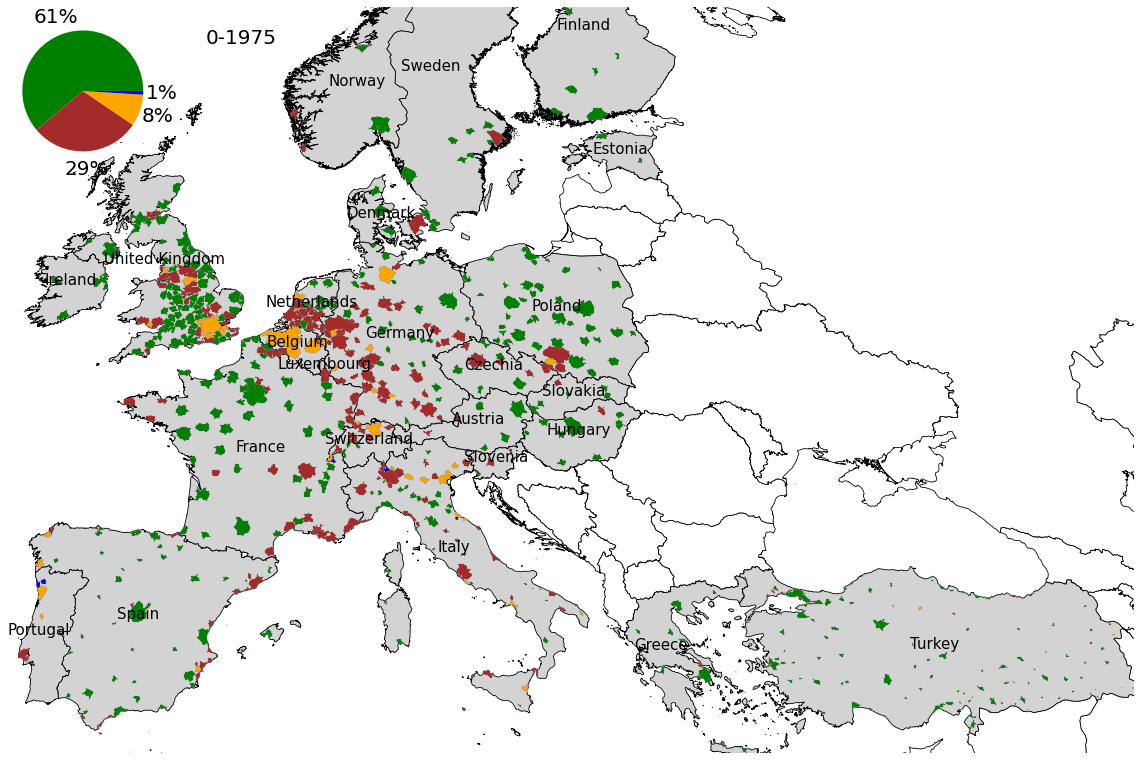

In [33]:
# Map FUAs' spatial development classification, generate figure 1
xmin, ymin, xmax, ymax = countries_gpd.total_bounds
fig, axes = plt.subplots(1,1,figsize=(20,15))

eu_gdf[eu_gdf['NAME_ENGL'].isin(non_OECDEU+bourdering)].plot(ax=axes,ec='k',linewidth=0.8,color='white')
eu_gdf[eu_gdf['NAME_ENGL'].isin(country_names)].plot(ax=axes,ec='k',linewidth=0.8,color='lightgrey')
for t in cntyname_annotations :
    axes.annotate(text=t[1], xy=t[0], ha='center',fontsize=15)

countries_gpd.plot(ax=axes,color=countries_gpd['1975color'],ec='grey',linewidth=0.3)

left, bottom, width, height = [0.1, 0.7, 0.14, 0.14]
ax2 = fig.add_axes([left, bottom, width, height])
# values = [np.sum(countries_gpd['0-1975 dominant mode']=='Compact'),np.sum(countries_gpd['0-1975 dominant mode']=='Medium compact'),
#           np.sum(countries_gpd['0-1975 dominant mode']=='Medium dispersed'),np.sum(countries_gpd['0-1975 dominant mode']=='Dispersed') ]
ax2.pie(values_075_avg, colors=('green','brown', 'orange', 'blue'),autopct='%.0f%%',textprops={'fontsize': 20},pctdistance=1.3)
title='0-1975'
plt.text(0.2, 0.95, title,horizontalalignment='center',fontsize=20,transform = axes.transAxes)
# green_patch = mpatches.Patch(color='green', label='Compact: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['0-1975 dominant mode']=='Compact'),
#                                      np.sum(countries_gpd['0-1975 dominant mode']=='Compact')/len(countries_gpd)))
# brown_patch = mpatches.Patch(color='brown', label='Medium compact: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['0-1975 dominant mode']=='Medium compact'),
#                                      np.sum(countries_gpd['0-1975 dominant mode']=='Medium compact')/len(countries_gpd)))
# orange_patch = mpatches.Patch(color='orange', label='Medium dispersed: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['0-1975 dominant mode']=='Medium dispersed'),
#                                      np.sum(countries_gpd['0-1975 dominant mode']=='Medium dispersed')/len(countries_gpd)))
# blue_patch = mpatches.Patch(color='blue', label='Dispersed: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['0-1975 dominant mode']=='Dispersed'),
#                                      np.sum(countries_gpd['0-1975 dominant mode']=='Dispersed')/len(countries_gpd)))
# _ = fig.legend(handles=[green_patch,brown_patch,orange_patch,blue_patch], bbox_to_anchor=(0.35,0.85),fontsize=20, ncol=1,
#                title='Dominant growth mode 0-1975',title_fontsize=20)

axes.set_xlim(xmin, xmax) 
axes.set_ylim(ymin, ymax)
axes.axis('off')

(-814000.0, 3845000.0, 4245000.0, 7359000.0)

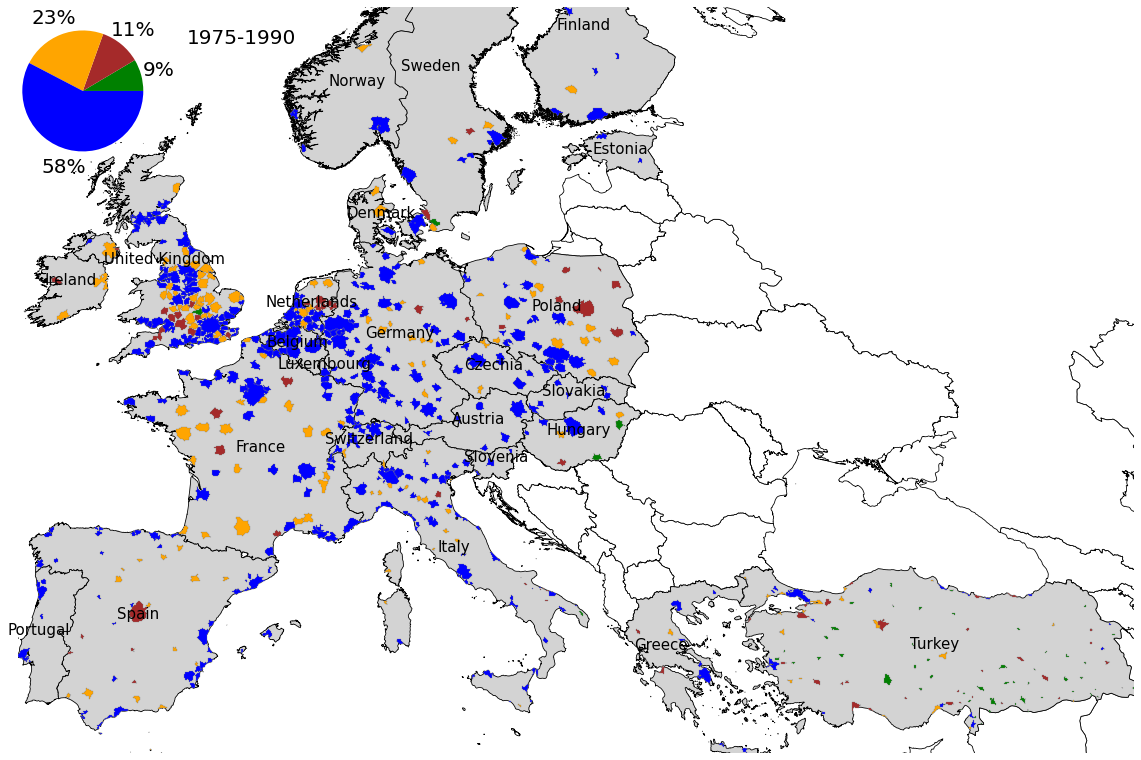

In [34]:
xmin, ymin, xmax, ymax = countries_gpd.total_bounds
fig, axes = plt.subplots(1,1,figsize=(20,15))

eu_gdf[eu_gdf['NAME_ENGL'].isin(non_OECDEU+bourdering)].plot(ax=axes,ec='k',linewidth=0.8,color='white')
eu_gdf[eu_gdf['NAME_ENGL'].isin(country_names)].plot(ax=axes,ec='k',linewidth=0.8,color='lightgrey')
for t in cntyname_annotations :
    axes.annotate(text=t[1], xy=t[0], ha='center',fontsize=15)

countries_gpd.plot(ax=axes,color=countries_gpd['7590color'],ec='grey',linewidth=0.3)

left, bottom, width, height = [0.1, 0.7, 0.14, 0.14]
ax2 = fig.add_axes([left, bottom, width, height])
# values = [np.sum(countries_gpd['1975-1990 dominant mode']=='Compact'),np.sum(countries_gpd['1975-1990 dominant mode']=='Medium compact'),
#           np.sum(countries_gpd['1975-1990 dominant mode']=='Medium dispersed'),np.sum(countries_gpd['1975-1990 dominant mode']=='Dispersed') ]
ax2.pie(values_7590_avg, colors=('green','brown', 'orange', 'blue'),autopct='%.0f%%',textprops={'fontsize': 20},pctdistance=1.3)
title='1975-1990'
plt.text(0.2, 0.95, title,horizontalalignment='center',fontsize=20,transform = axes.transAxes)
# green_patch = mpatches.Patch(color='green', label='Compact: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['1975-1990 dominant mode']=='Compact'),
#                                      np.sum(countries_gpd['1975-1990 dominant mode']=='Compact')/len(countries_gpd)))
# brown_patch = mpatches.Patch(color='brown', label='Medium compact: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['1975-1990 dominant mode']=='Medium compact'),
#                                      np.sum(countries_gpd['1975-1990 dominant mode']=='Medium compact')/len(countries_gpd)))
# orange_patch = mpatches.Patch(color='orange', label='Medium dispersed: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['1975-1990 dominant mode']=='Medium dispersed'),
#                                      np.sum(countries_gpd['1975-1990 dominant mode']=='Medium dispersed')/len(countries_gpd)))
# blue_patch = mpatches.Patch(color='blue', label='Dispersed: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['1975-1990 dominant mode']=='Dispersed'),
#                                      np.sum(countries_gpd['1975-1990 dominant mode']=='Dispersed')/len(countries_gpd)))
# _ = fig.legend(handles=[green_patch,brown_patch,orange_patch,blue_patch], bbox_to_anchor=(0.35,0.85),fontsize=20, ncol=1,
#                title='Dominant growth mode 1975-1990',title_fontsize=20)

axes.set_xlim(xmin, xmax) 
axes.set_ylim(ymin, ymax)
axes.axis('off')

(-814000.0, 3845000.0, 4245000.0, 7359000.0)

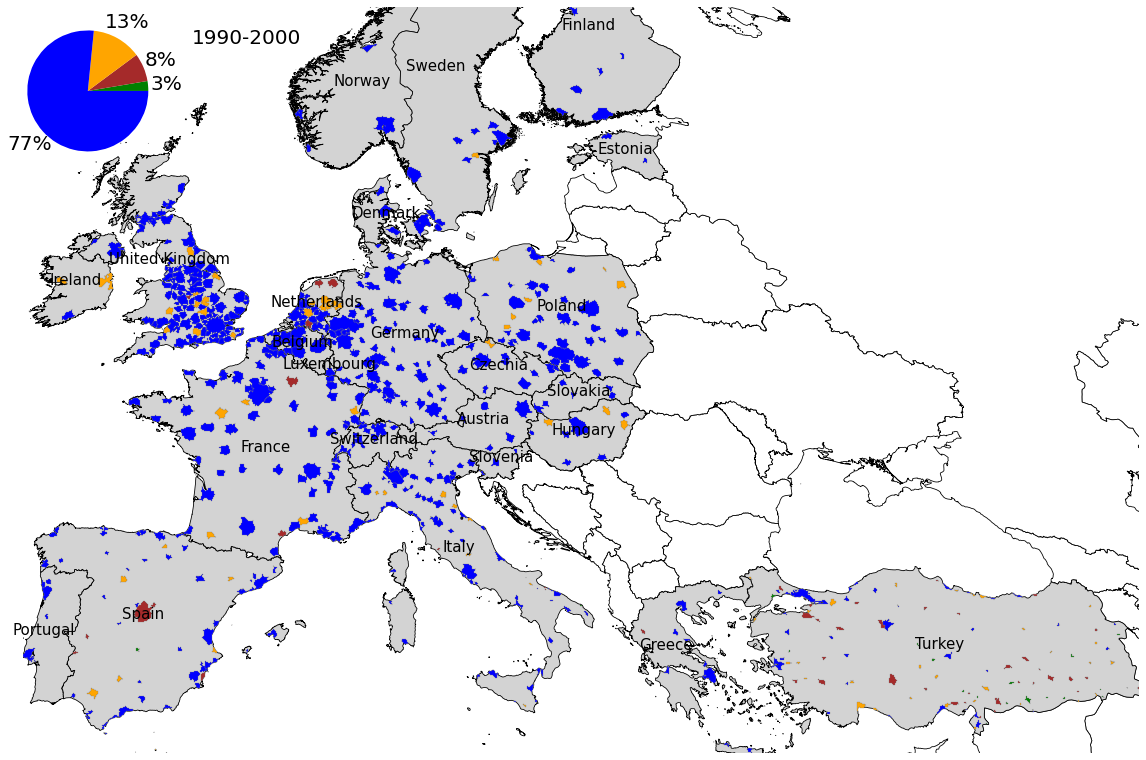

In [35]:
xmin, ymin, xmax, ymax = countries_gpd.total_bounds
fig, axes = plt.subplots(1,1,figsize=(20,15))

eu_gdf[eu_gdf['NAME_ENGL'].isin(non_OECDEU+bourdering)].plot(ax=axes,ec='k',linewidth=0.8,color='white')
eu_gdf[eu_gdf['NAME_ENGL'].isin(country_names)].plot(ax=axes,ec='k',linewidth=0.8,color='lightgrey')
for t in cntyname_annotations :
    axes.annotate(text=t[1], xy=t[0], ha='center',fontsize=15)

countries_gpd.plot(ax=axes,color=countries_gpd['9000color'],ec='grey',linewidth=0.3)
left, bottom, width, height = [0.1, 0.7, 0.14, 0.14]
ax2 = fig.add_axes([left, bottom, width, height])
# values = [np.sum(countries_gpd['1990-2000 dominant mode']=='Compact'),np.sum(countries_gpd['1990-2000 dominant mode']=='Medium compact'),
#           np.sum(countries_gpd['1990-2000 dominant mode']=='Medium dispersed'),np.sum(countries_gpd['1990-2000 dominant mode']=='Dispersed') ]
ax2.pie(values_9000_avg, colors=('green','brown', 'orange', 'blue'),autopct='%.0f%%',textprops={'fontsize': 20},pctdistance=1.3)
title='1990-2000'
plt.text(0.2, 0.95, title,horizontalalignment='center',fontsize=20,transform = axes.transAxes)
# green_patch = mpatches.Patch(color='green', label='Compact: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['1990-2000 dominant mode']=='Compact'),
#                                      np.sum(countries_gpd['1990-2000 dominant mode']=='Compact')/len(countries_gpd)))
# brown_patch = mpatches.Patch(color='brown', label='Medium compact: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['1990-2000 dominant mode']=='Medium compact'),
#                                      np.sum(countries_gpd['1990-2000 dominant mode']=='Medium compact')/len(countries_gpd)))
# orange_patch = mpatches.Patch(color='orange', label='Medium dispersed: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['1990-2000 dominant mode']=='Medium dispersed'),
#                                      np.sum(countries_gpd['1990-2000 dominant mode']=='Medium dispersed')/len(countries_gpd)))
# blue_patch = mpatches.Patch(color='blue', label='Dispersed: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['1990-2000 dominant mode']=='Dispersed'),
#                                      np.sum(countries_gpd['1990-2000 dominant mode']=='Dispersed')/len(countries_gpd)))
# _ = fig.legend(handles=[green_patch,brown_patch,orange_patch,blue_patch], bbox_to_anchor=(0.35,0.85),fontsize=20, ncol=1,
#                title='Dominant growth mode 1990-2000',title_fontsize=20)

axes.set_xlim(xmin, xmax) 
axes.set_ylim(ymin, ymax)
axes.axis('off')

(-814000.0, 3845000.0, 4245000.0, 7359000.0)

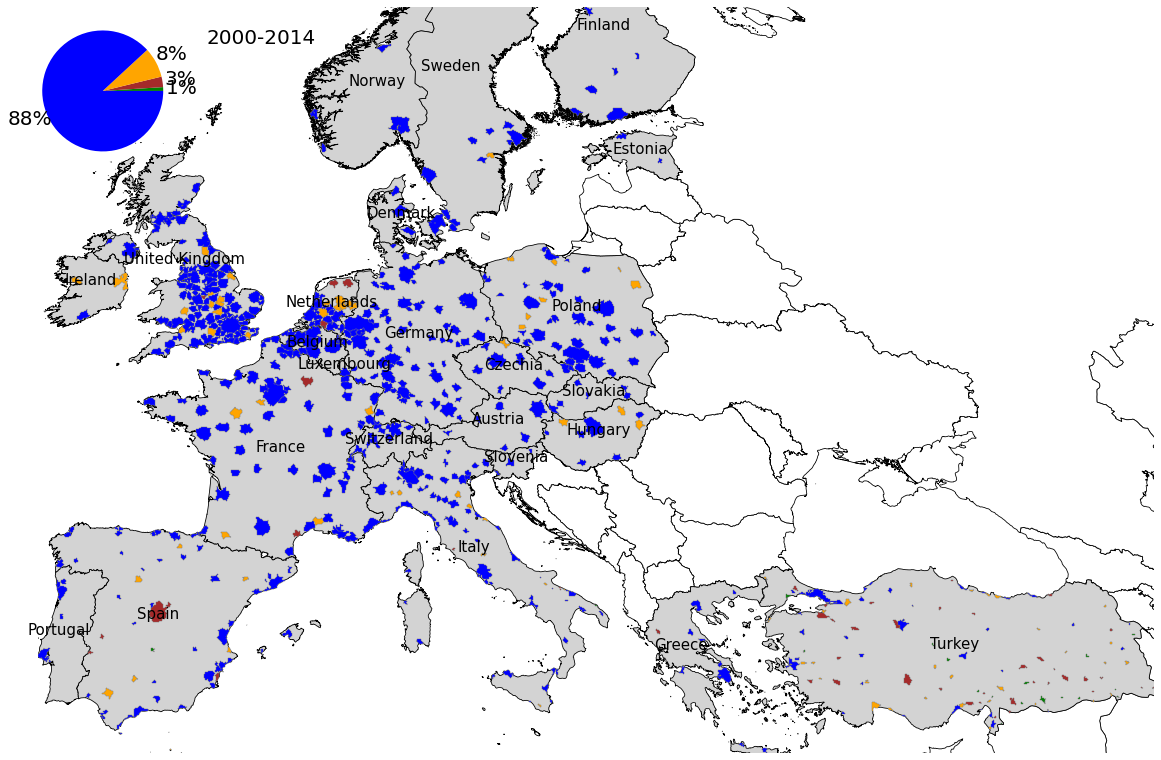

In [36]:
xmin, ymin, xmax, ymax = countries_gpd.total_bounds
fig, axes = plt.subplots(1,1,figsize=(20,15))

eu_gdf[eu_gdf['NAME_ENGL'].isin(non_OECDEU+bourdering)].plot(ax=axes,ec='k',linewidth=0.8,color='white')
eu_gdf[eu_gdf['NAME_ENGL'].isin(country_names)].plot(ax=axes,ec='k',linewidth=0.8,color='lightgrey')
for t in cntyname_annotations :
    axes.annotate(text=t[1], xy=t[0], ha='center',fontsize=15)

countries_gpd.plot(ax=axes,color=countries_gpd['0014color'],ec='grey',linewidth=0.3)

countries_gpd.plot(ax=axes,color=countries_gpd['9000color'],ec='grey',linewidth=0.3)
left, bottom, width, height = [0.1, 0.7, 0.14, 0.14]
ax2 = fig.add_axes([left, bottom, width, height])
# values = [np.sum(countries_gpd['2000-2014 dominant mode']=='Compact'),np.sum(countries_gpd['2000-2014 dominant mode']=='Medium compact'),
#           np.sum(countries_gpd['2000-2014 dominant mode']=='Medium dispersed'),np.sum(countries_gpd['2000-2014 dominant mode']=='Dispersed') ]
ax2.pie(values_0014_avg, colors=('green','brown', 'orange', 'blue'),autopct='%.0f%%',textprops={'fontsize': 20},pctdistance=1.3)
title='2000-2014'
plt.text(0.2, 0.95, title,horizontalalignment='center',fontsize=20,transform = axes.transAxes)
# green_patch = mpatches.Patch(color='green', label='Compact: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['2000-2014 dominant mode']=='Compact'),
#                                      np.sum(countries_gpd['2000-2014 dominant mode']=='Compact')/len(countries_gpd)))
# brown_patch = mpatches.Patch(color='brown', label='Medium compact: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['2000-2014 dominant mode']=='Medium compact'),
#                                      np.sum(countries_gpd['2000-2014 dominant mode']=='Medium compact')/len(countries_gpd)))
# orange_patch = mpatches.Patch(color='orange', label='Medium dispersed: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['2000-2014 dominant mode']=='Medium dispersed'),
#                                      np.sum(countries_gpd['2000-2014 dominant mode']=='Medium dispersed')/len(countries_gpd)))
# blue_patch = mpatches.Patch(color='blue', label='Dispersed: {}, {:.0%}'.format(
#                                      np.sum(countries_gpd['2000-2014 dominant mode']=='Dispersed'),
#                                      np.sum(countries_gpd['2000-2014 dominant mode']=='Dispersed')/len(countries_gpd)))
# _ = fig.legend(handles=[green_patch,brown_patch,orange_patch,blue_patch], bbox_to_anchor=(0.35,0.85),fontsize=20, ncol=1,
#                title='Dominant growth mode 2000-2014',title_fontsize=20)

axes.set_xlim(xmin, xmax) 
axes.set_ylim(ymin, ymax)
axes.axis('off')

In [39]:
num_green = np.zeros((2,100))
num_blue = np.zeros((2,100))
for j in range(100):
    #period 0-1975 best cluster counts dataframe
    eddf_1975 = pd.DataFrame(index=FUAs,columns=['Compact','Medium compact','Medium dispersed','Dispersed'])
    for i in range(len(FUAs)):
        ed_df,compact,mediumC,mediumS,sprawl = plot_ks(i,timeperiod=0)
        compact_60,mediumC_60,mediumS_60,sprawl_60 = np.array(compact),np.random.choice(mediumC, size=60, replace=False),\
                                                     np.random.choice(mediumS, size=60, replace=False),\
                                                     np.random.choice(sprawl, size=60, replace=False)
        compact_tuple,mediumC_tuple,mediumS_tuple,sprawl_tuple = list(zip(compact_60,['Compact']*60)),list(zip(mediumC_60,['Medium compact']*60)),\
                                                             list(zip(mediumS_60,['Medium dispersed']*60)),list(zip(sprawl_60,['Dispersed']*60))
        all_tuples = np.asarray(compact_tuple+mediumC_tuple+mediumS_tuple+sprawl_tuple)
        all_tuples_60tag = all_tuples[all_tuples[:, 0].argsort()][:60][:,1]
        unique, counts = np.unique(all_tuples_60tag,return_counts=True)
        eddf_1975.iloc[i] = dict(zip(unique, counts))
    eddf_1975 = eddf_1975.fillna(0)
    #period 1975-1990 best cluster counts dataframe
    eddf_7590 = pd.DataFrame(index=FUAs,columns=['Compact','Medium compact','Medium dispersed','Dispersed'])
    for i in range(len(FUAs)):
        ed_df,compact,mediumC,mediumS,sprawl = plot_ks(i,timeperiod=1)
        compact_60,mediumC_60,mediumS_60,sprawl_60 = np.array(compact),np.random.choice(mediumC, size=60, replace=False),\
                                                     np.random.choice(mediumS, size=60, replace=False),\
                                                     np.random.choice(sprawl, size=60, replace=False)
        compact_tuple,mediumC_tuple,mediumS_tuple,sprawl_tuple = list(zip(compact_60,['Compact']*60)),list(zip(mediumC_60,['Medium compact']*60)),\
                                                             list(zip(mediumS_60,['Medium dispersed']*60)),list(zip(sprawl_60,['Dispersed']*60))
        all_tuples = np.asarray(compact_tuple+mediumC_tuple+mediumS_tuple+sprawl_tuple)
        all_tuples_60tag = all_tuples[all_tuples[:, 0].argsort()][:60][:,1]
        unique, counts = np.unique(all_tuples_60tag,return_counts=True)
        eddf_7590.iloc[i] = dict(zip(unique, counts))
    eddf_7590 = eddf_7590.fillna(0)
    #period 1990-2000 best cluster counts dataframe
    eddf_9000 = pd.DataFrame(index=FUAs,columns=['Compact','Medium compact','Medium dispersed','Dispersed'])
    for i in range(len(FUAs)):
        ed_df,compact,mediumC,mediumS,sprawl = plot_ks(i,timeperiod=2)
        compact_60,mediumC_60,mediumS_60,sprawl_60 = np.array(compact),np.random.choice(mediumC, size=60, replace=False),\
                                                     np.random.choice(mediumS, size=60, replace=False),\
                                                     np.random.choice(sprawl, size=60, replace=False)
        compact_tuple,mediumC_tuple,mediumS_tuple,sprawl_tuple = list(zip(compact_60,['Compact']*60)),list(zip(mediumC_60,['Medium compact']*60)),\
                                                             list(zip(mediumS_60,['Medium dispersed']*60)),list(zip(sprawl_60,['Dispersed']*60))
        all_tuples = np.asarray(compact_tuple+mediumC_tuple+mediumS_tuple+sprawl_tuple)
        all_tuples_60tag = all_tuples[all_tuples[:, 0].argsort()][:60][:,1]
        unique, counts = np.unique(all_tuples_60tag,return_counts=True)
        eddf_9000.iloc[i] = dict(zip(unique, counts))
    eddf_9000 = eddf_9000.fillna(0)
    #period 2000-2014 best cluster counts dataframe
    eddf_0014 = pd.DataFrame(index=FUAs,columns=['Compact','Medium compact','Medium dispersed','Dispersed'])
    for i in range(len(FUAs)):
        ed_df,compact,mediumC,mediumS,sprawl = plot_ks(i,timeperiod=3)
        compact_60,mediumC_60,mediumS_60,sprawl_60 = np.array(compact),np.random.choice(mediumC, size=60, replace=False),\
                                                     np.random.choice(mediumS, size=60, replace=False),\
                                                     np.random.choice(sprawl, size=60, replace=False)
        compact_tuple,mediumC_tuple,mediumS_tuple,sprawl_tuple = list(zip(compact_60,['Compact']*60)),list(zip(mediumC_60,['Medium compact']*60)),\
                                                             list(zip(mediumS_60,['Medium dispersed']*60)),list(zip(sprawl_60,['Dispersed']*60))
        all_tuples = np.asarray(compact_tuple+mediumC_tuple+mediumS_tuple+sprawl_tuple)
        all_tuples_60tag = all_tuples[all_tuples[:, 0].argsort()][:60][:,1]
        unique, counts = np.unique(all_tuples_60tag,return_counts=True)
        eddf_0014.iloc[i] = dict(zip(unique, counts))
    eddf_0014 = eddf_0014.fillna(0)

    eddf_1975["Name"] = "0-1975"
    eddf_7590["Name"] = "1975-1990"
    eddf_9000["Name"] = "1990-2000"
    eddf_0014["Name"] = "2000-2014"
    dfall = pd.concat([pd.melt(i.reset_index(),
                               id_vars=["Name", "index"]) # transform in tidy format each df
                       for i in [eddf_1975, eddf_7590, eddf_9000, eddf_0014]],
                       ignore_index=True)
    dfall = dfall.rename(columns={'variable': 'Growth modes'})

    more_dispersed0014than7500 = (eddf_0014['Dispersed']-eddf_7590['Dispersed']>0).to_dict()
    countries_gpd['more_dispersed0014than7500'] = countries_gpd['eFUA_name'].map(more_dispersed0014than7500)
    countries_gpd.loc[:, 'more_dispersed0014than7500'] = countries_gpd['more_dispersed0014than7500'].apply(lambda x: 'blue' if x == True else 'green')
    
    num_green[0][j]= np.sum(countries_gpd['more_dispersed0014than7500']=='green')
    num_blue[0][j]= np.sum(countries_gpd['more_dispersed0014than7500']=='blue')

In [40]:
num_green_avg = np.average(num_green[0])
num_blue_avg = np.average(num_blue[0])
pct_blue_avg = 100 * num_blue_avg/len(countries_gpd)

(-814000.0, 3845000.0, 4245000.0, 7359000.0)

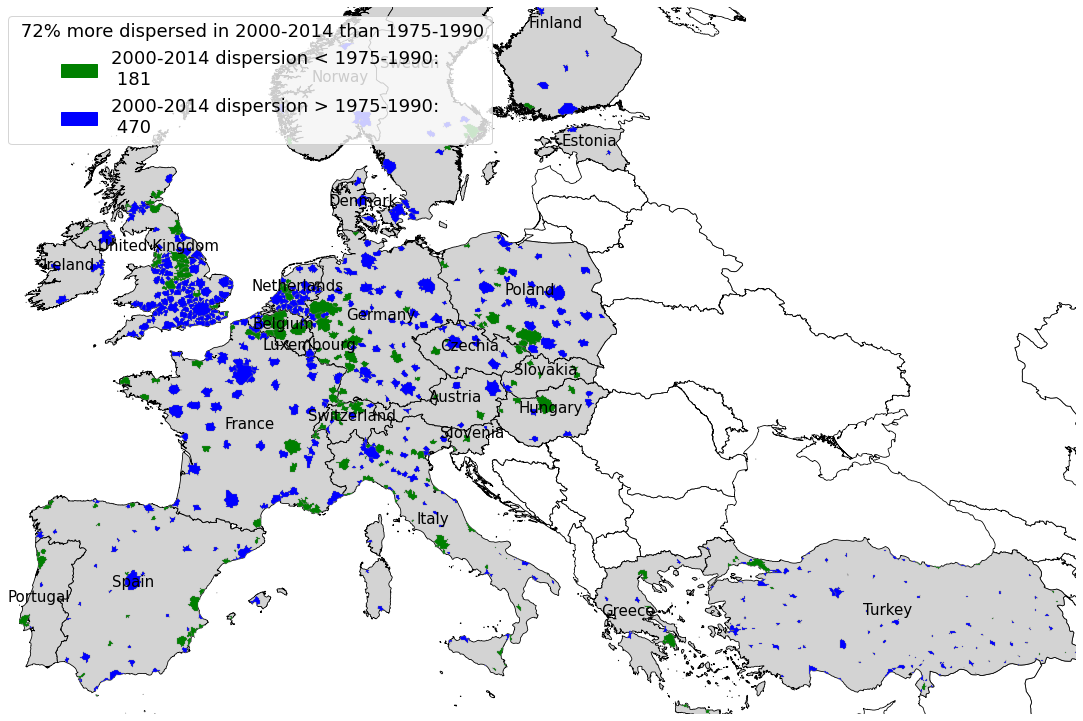

In [41]:
# Generate figure 2
xmin, ymin, xmax, ymax = countries_gpd.total_bounds
fig, axes = plt.subplots(1,1,figsize=(20,13))
eu_gdf[eu_gdf['NAME_ENGL'].isin(non_OECDEU+bourdering)].plot(ax=axes,ec='k',linewidth=0.8,color='white')
eu_gdf[eu_gdf['NAME_ENGL'].isin(country_names)].plot(ax=axes,ec='k',linewidth=0.8,color='lightgrey')
for t in cntyname_annotations :
    axes.annotate(text=t[1], xy=t[0], ha='center',fontsize=15)

countries_gpd.plot(ax=axes,color=countries_gpd['more_dispersed0014than7500'],ec='grey',linewidth=0.3)
# river_gdf[river_gdf['NAME'].isin(['Rhine','Po'])].plot(ax=axes,color='cyan',linewidth=2,alpha=0.8)

green_patch = mpatches.Patch(color='green', label='2000-2014 dispersion < 1975-1990:\n %d' % (num_green_avg))
blue_patch = mpatches.Patch(color='blue', label='2000-2014 dispersion > 1975-1990:\n %d' % (num_blue_avg))
_ = fig.legend(handles=[green_patch,blue_patch], bbox_to_anchor=(0.48,0.88),fontsize=18, ncol=1,
               title=r" %.0f%% more dispersed in 2000-2014 than 1975-1990"  % (pct_blue_avg),
               title_fontsize=18)

axes.set_xlim(xmin, xmax) 
axes.set_ylim(ymin, ymax)
axes.axis('off')
# fig.suptitle(r" %.0f%% more sprawling in 2000-2014 than 1975-1990"  % (100 * np.sum(countries_gpd['more_dispersed0014than7500']=='blue')/len(countries_gpd)),y=0.9,fontsize=20)